In [1]:
import pandas as pd
import os
import glob

def process_match(ball_csv_path, info_csv_path):
    # Extract match ID
    match_id = os.path.basename(ball_csv_path).replace('.csv', '')

    # === STEP 1.1: LOAD BALL-BY-BALL DATA ===
    df = pd.read_csv(ball_csv_path)
    df['match_id'] = match_id

    # === STEP 1.2: COMPUTE MATCH STATE FEATURES ===
    df[['over', 'ball_in_over']] = df['ball'].astype(str).str.split('.', expand=True).astype(int)
    df['ball_number'] = df['over'] * 6 + df['ball_in_over']
    df['total_runs'] = df['runs_off_bat'] + df['extras']
    df['cumulative_runs'] = df.groupby('innings')['total_runs'].cumsum()
    df['wicket'] = df['player_dismissed'].notnull().astype(int)
    df['cumulative_wickets'] = df.groupby('innings')['wicket'].cumsum()
    df['ball_count'] = df.groupby('innings').cumcount() + 1
    df['balls_remaining'] = 120 - df['ball_count']
    df['wickets_remaining'] = 10 - df['cumulative_wickets']

    # === STEP 1.3: ADD TARGET AND RUNS REMAINING ===
    target = df[df['innings'] == 1]['total_runs'].sum()
    df['target'] = target
    df['runs_remaining'] = df['target'] - df['cumulative_runs']
    df.loc[df['innings'] == 1, 'runs_remaining'] = None

    # === MERGE MATCH INFO ===
    with open(info_csv_path, 'r') as f:
        lines = f.readlines()

    info_dict = {}
    for line in lines:
        parts = line.strip().split(',', 2)
        if len(parts) == 3 and parts[0] == 'info':
            key, value = parts[1], parts[2]
            if key in info_dict:
                if isinstance(info_dict[key], list):
                    info_dict[key].append(value)
                else:
                    info_dict[key] = [info_dict[key], value]
            else:
                info_dict[key] = value

    # Add metadata as columns
    for key, value in info_dict.items():
        df[f'info_{key}'] = str(value)

        # === STEP 1.4: ADD WIN/LOSS LABEL (for both innings) ===
    if 'winner' in info_dict and 'team' in info_dict:
        match_winner = info_dict['winner']

        # Assign win=1 if current batting team won, else 0
        df['won'] = df['batting_team'].apply(lambda x: int(x == match_winner))
    else:
        df['won'] = None  # fallback if info is missing
    return df

# === BATCH PROCESS ALL MATCHES ===
def process_all_matches(folder_path):
    ball_files = sorted(glob.glob(os.path.join(folder_path, "*.csv")))
    all_matches = []

    for ball_path in ball_files:
        if ball_path.endswith("_info.csv") or ball_path.endswith("all_matches.csv"):
            continue  # skip info files

        match_id = os.path.basename(ball_path).replace(".csv", "")
        info_path = os.path.join(folder_path, f"{match_id}_info.csv")

        if os.path.exists(info_path):
            try:
                match_df = process_match(ball_path, info_path)
                all_matches.append(match_df)
            except Exception as e:
                print(f"Error processing {match_id}: {e}")
        else:
            print(f"No info file for match {match_id}")

    final_df = pd.concat(all_matches, ignore_index=True)
    return final_df

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
full_df = process_all_matches("ipl_csv2/")

In [3]:
print(full_df.dtypes)

match_id                   object
season                     object
start_date                 object
venue                      object
innings                     int64
ball                      float64
batting_team               object
bowling_team               object
striker                    object
non_striker                object
bowler                     object
runs_off_bat                int64
extras                      int64
wides                     float64
noballs                   float64
byes                      float64
legbyes                   float64
penalty                   float64
wicket_type                object
player_dismissed           object
other_wicket_type         float64
other_player_dismissed    float64
over                        int64
ball_in_over                int64
ball_number                 int64
total_runs                  int64
cumulative_runs             int64
wicket                      int64
cumulative_wickets          int64
ball_count    

In [4]:
def clean_final_dataframe(df):
    df = df.copy()

    # 1. Drop fully empty columns
    df = df.dropna(axis=1, how='all')

    # 2. Clean stringified list columns
    list_like_cols = ['info_player', 'info_registry', 'info_event', 'info_team', 'info_umpire']
    for col in list_like_cols:
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                .str.strip("[]")
                .str.replace("'", "", regex=False)
                .str.replace('"', "", regex=False)
            )

    # 3. Drop high-cardinality or irrelevant columns
    drop_cols = ['Unnamed: 0', 'start_date', 'info_date', 'info_player', 'info_registry']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # 4. Convert numeric-looking object columns
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except:
                pass

    return df

In [5]:
clean_df = clean_final_dataframe(full_df)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

def train_win_probability_model(clean_df):
    # === Step 1: Filter usable rows ===
    df_model = clean_df[clean_df['won'].notna()].copy()

    # === Step 2: Handle missing values ===
    df_model['runs_remaining'] = df_model['runs_remaining'].fillna(-1)
    df_model['balls_remaining'] = df_model['balls_remaining'].fillna(0)
    df_model['wickets_remaining'] = df_model['wickets_remaining'].fillna(0)

    # === Step 3: Define features and target ===
    features = [
        'innings',
        'balls_remaining',
        'runs_remaining',
        'cumulative_runs',
        'wickets_remaining'
    ]
    target = 'won'

    X = df_model[features]
    y = df_model[target]

    # === Step 4: Train-test split ===
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # === Step 5: Train model ===
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # === Step 6: Predict win probabilities ===
    df_model['win_probability'] = model.predict_proba(X)[:, 1]

    # === Step 7: Evaluate performance ===
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print("Model Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC AUC:  {roc_auc:.4f}")

    return model, df_model

In [7]:
# Assuming you already ran clean_df = clean_final_dataframe(full_df)
model, df_model = train_win_probability_model(clean_df)

Model Performance:
  Accuracy: 0.6669
  ROC AUC:  0.7365


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def train_xgboost_win_model_expanded(clean_df):
    df_model = clean_df[clean_df['won'].notna()].copy()

    # === Feature Engineering ===
    df_model['overs_so_far'] = df_model['ball_count'] // 6 + (df_model['ball_count'] % 6) / 6
    df_model['run_rate'] = df_model['cumulative_runs'] / df_model['overs_so_far'].replace(0, 1)
    df_model['required_run_rate'] = df_model['runs_remaining'] / (df_model['balls_remaining'] / 6).replace(0, 1)
    df_model['delta_run_rate'] = df_model['run_rate'] - df_model['required_run_rate']

    # Over-based features
    df_model['over_number'] = df_model['ball_count'] // 6 + 1
    df_model['is_powerplay'] = (df_model['over_number'] <= 6).astype(int)
    df_model['is_death'] = (df_model['over_number'] >= 16).astype(int)

    # Handle NaNs
    df_model.fillna({
        'runs_remaining': -1,
        'balls_remaining': 0,
        'wickets_remaining': 0,
        'run_rate': 0,
        'required_run_rate': -1,
        'delta_run_rate': 0
    }, inplace=True)

    # Label encode categorical features
    for col in ['batting_team', 'bowling_team', 'info_venue', 'striker', 'bowler']:
        if col in df_model.columns:
            df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

    # === Final Feature List ===
    features = [
        'innings',
        'balls_remaining',
        'runs_remaining',
        'cumulative_runs',
        'wickets_remaining',
        'run_rate',
        'required_run_rate',
        'delta_run_rate',
        'is_powerplay',
        'is_death',
        'batting_team',
        'bowling_team',
        'info_venue'
    ]
    target = 'won'

    X = df_model[features]
    y = df_model[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Predict win probabilities
    df_model['win_probability'] = model.predict_proba(X)[:, 1]

    # Evaluate performance
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print("🚀 XGBoost Model Performance (Expanded Features)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC:  {roc_auc:.4f}")

    # Plot feature importances
    plot_feature_importance(model, features)

    return model, df_model

# === Plot Feature Importances ===
def plot_feature_importance(model, feature_names):
    plt.figure(figsize=(10, 5))
    importances = model.feature_importances_
    sorted_idx = importances.argsort()
    plt.barh(range(len(sorted_idx)), importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title("Feature Importances (XGBoost)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

def plot_win_probability(df_model, match_id):
    match_df = df_model[df_model['match_id'] == match_id].copy()

    if match_df.empty:
        print(f"No data found for match ID: {match_id}")
        return

    match_df = match_df.sort_values(['innings', 'ball_count'])

    plt.figure(figsize=(12, 5))

    for innings in [1, 2]:
        innings_df = match_df[match_df['innings'] == innings]
        if not innings_df.empty:
            plt.plot(innings_df['ball_count'], innings_df['win_probability'], label=f"Innings {innings}")

    plt.xlabel("Ball number")
    plt.ylabel("Win Probability")
    plt.title(f"Win Probability Progression - Match {match_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/opt/miniconda3/envs/6.86x/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [08:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 XGBoost Model Performance (Expanded Features)
Accuracy: 0.7150
ROC AUC:  0.8088


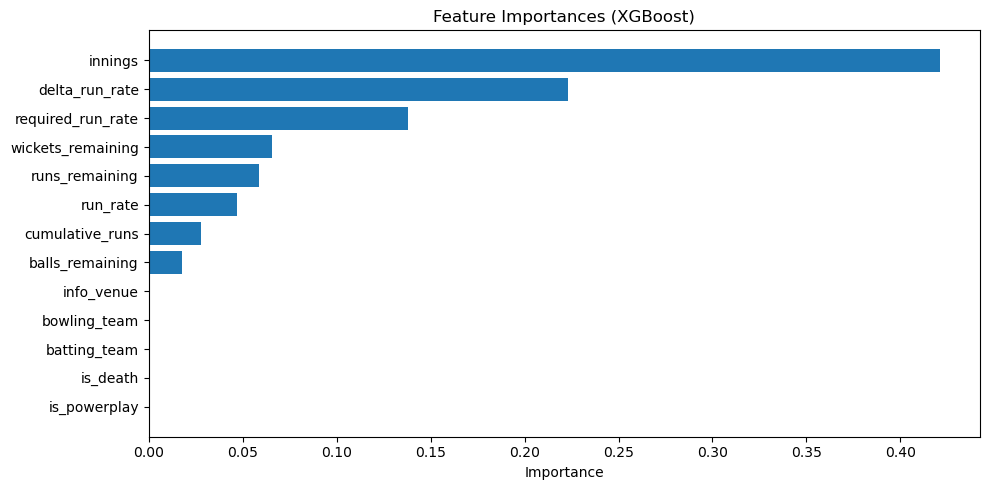

In [29]:
# Step 1: Train the model
model, df_model = train_xgboost_win_model_expanded(clean_df)

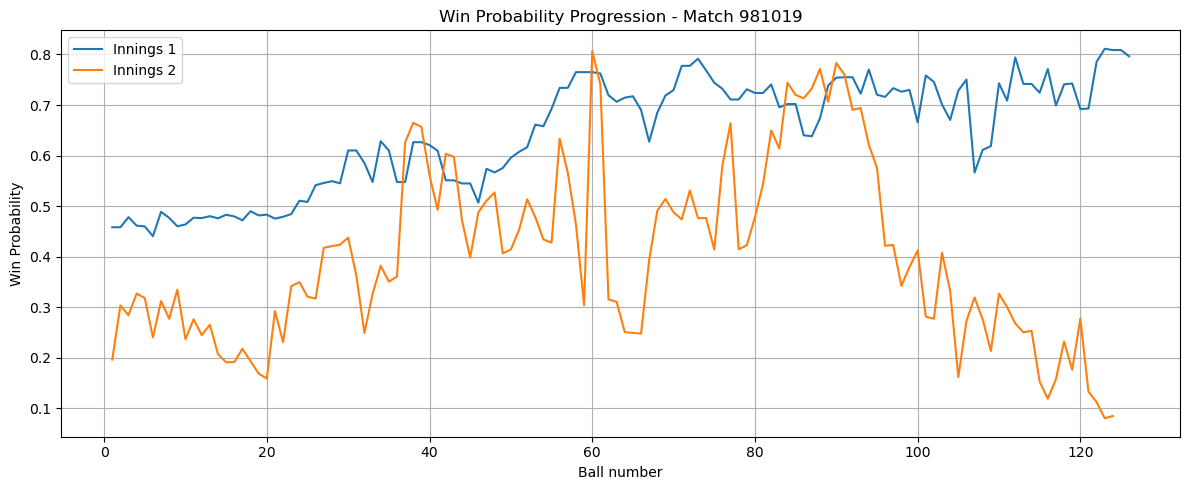

In [30]:
# Step 2: Plot win probability for a specific match
plot_win_probability(df_model, match_id=981019)

In [18]:
df_model['match_id']

0         1082591
1         1082591
2         1082591
3         1082591
4         1082591
           ...   
266697     981019
266698     981019
266699     981019
266700     981019
266701     981019
Name: match_id, Length: 262578, dtype: int64